In [1]:
# import the general stuff
import os
from os import getcwd
import matplotlib.pyplot as plt
import pandas as pd 
import os

import numpy as np

#cyclic learning rate
from clr_callback import * 

#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

import tensorflow_model_optimization as tfmot

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from skimage import color, util, exposure
from skimage.morphology import disk
from skimage.filters import rank

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.6.0


In [2]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chk_null (use `wandb login --relogin` to force relogin)


True

In [3]:
#code for GPU mem growth

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
for gpu in tf.config.list_physical_devices('GPU'):
    print(gpu)


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')


### Read data and Preprocess

#### Adaptive EQ Processing

In [5]:
### Converts original pictures to adaptive eq'ised images and stores in directory processed. 
### Gustav J. Braun, “Image Lightness Rescaling Using Sigmoidal Contrast Enhancement Functions”, http://markfairchild.org/PDFs/PAP07.pdf
### https://en.wikipedia.org/wiki/Histogram_equalization

# from os import walk
# from skimage import io

# f = []
# for (dirpath, dirnames, filenames) in walk(train_data_dir):
#     f.extend(filenames)
# f

# for each in f:
# #     print(train_data_direach)
#     img = io.imread(train_data_dir+'/'+each)
#     img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
#     io.imsave('../data/Processed/'+each, img_adapteq)

#### Read the image attributes

In [6]:
#data
df = pd.read_csv('../data/SedMLdata.csv')
df.head()

,CropName,D2mm,D5mm,D10mm,D16mm,D25mm,D50mm,D75mm,D84mm,D90mm,D95mm,D98mm,skew,kurtosis
0,F1crop1.jpg,0.202,0.255,0.328,0.417,0.600,1.049,1.475,1.690,1.941,2.243,2.621,-0.310,0.992
1,F1crop2.jpg,0.168,0.194,0.224,0.256,0.305,0.481,0.974,1.420,2.143,2.982,3.980,0.298,0.965
2,F1crop3.jpg,0.128,0.144,0.160,0.176,0.198,0.304,0.540,0.700,0.897,1.172,1.598,0.247,0.857
3,F1crop4.jpg,0.218,0.273,0.346,0.429,0.621,1.283,1.821,2.040,2.241,2.532,2.873,-0.398,0.850
4,F1crop5.jpg,0.134,0.153,0.174,0.194,0.221,0.332,0.780,1.139,1.532,1.851,2.376,0.384,0.810


#### For Sequential Single Output (Distribution)

In [7]:
# Define dirs and files
train_data_dir = '../data/Processed/'
# train_data_dir = '../data/CropPics/'

In [8]:
# split = 0.5

# df = pd.read_csv('../data/SedMLdata.csv')
# columns=["D2mm", "D5mm", "D10mm", "D16mm",
# "D25mm","D50mm", "D75mm", "D84mm", "D90mm",
# "D95mm", "D98mm", "skew", "kurtosis"]

# train_datagen = ImageDataGenerator(
#                                    horizontal_flip = True,
#                                    vertical_flip = True,
#                                    fill_mode='nearest',
#                                     validation_split = split,
#                                   )

# def multiple_outputs(generator, dataframe, image_dir, columns,class_mode, batch_size, color_mode, imsize, subset):
#     gen = generator.flow_from_dataframe(
#         dataframe = dataframe,
#         directory = image_dir,
#         class_mode = 'raw',
#         target_size=imsize,
#         batch_size=batch_size,
#         x_col = 'CropName',
#         y_col = columns,
#         color_mode = color_mode,
#         subset=subset)
    
#     while True:
#         gnext = gen.next()
#         # return image batch and 3 sets of lables
#         yield gnext[0], [gnext[1][:,:10], gnext[1][:,10], gnext[1][:,11]]


# train_generator = multiple_outputs(generator=train_datagen,
#                                    dataframe = df,
#                                    image_dir = train_data_dir,
#                                    batch_size = batch_size,
#                                    class_mode = 'raw',
#                                    imsize = imsize,
#                                    columns=columns,
#                                    color_mode = c_mode,
#                                    subset = 'training')
# validation_generator =  multiple_outputs(
#                                    generator=train_datagen,
#                                    dataframe=df,
#                                    image_dir = train_data_dir,
#                                    batch_size = batch_size,
#                                    class_mode = 'raw',
#                                    imsize = imsize,
#                                    columns=columns,
#                                    color_mode = c_mode,
#                                    subset = 'validation')

In [9]:
# for each in train_generator:
#     print(each[1])
#     break

In [10]:
#build data generators for training and validaton

split = 0.2

df = pd.read_csv('../data/SedMLdata.csv')
columns=["D2mm", "D5mm", "D10mm", "D16mm",
"D25mm","D50mm", "D75mm", "D84mm", "D90mm",
"D95mm", "D98mm"] # "skew", "kurtosis" not included


# Contrast stretching
def contrast_stretching(img):
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    return img_rescale

# Histogram equalization
def HE(img):
    img_eq = exposure.equalize_hist(img)
    return img_eq

# Adaptive histogram equalization
def AHE(img):
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.1)
    return img_adapteq

# Rank equalization
def REQ(img):
    selem = disk(30)
    img_eq = rank.equalize(img, selem=selem)
    return img_eq

# Add our data-augmentation parameters to ImageDataGenerator and split data
train_datagen = ImageDataGenerator(
                                      #include preprocessing steps in the generator  
                        #             preprocessing_function = contrast_adjusment,
                        #             preprocessing_function = HE,
                        #             preprocessing_function = AHE,
                                   rescale = 1./255.,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   fill_mode='nearest',
                                    validation_split = split,
                                  )


#set batch Size
batch_size = 4

# c_ch = 1
# c_mode = 'grayscale'
c_ch = 3
c_mode = 'rgb'

#set Image size (RGB so imshape is 3)
pix_dim = 1024
imsize = (pix_dim, pix_dim) 
imshape = (pix_dim, pix_dim, c_ch)

# Flow training images in batches 
train_generator = train_datagen.flow_from_dataframe(dataframe = df,
                                                    directory = train_data_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'raw',
                                                    x_col = 'CropName',
                                                    y_col = columns,
                                                    target_size = imsize,
                                                    color_mode = c_mode,
                                                    subset = 'training')

# Flow validation images in batches 
validation_generator =  train_datagen.flow_from_dataframe(dataframe=df,
                                                          directory = train_data_dir,
                                                          batch_size = batch_size,
                                                          class_mode = 'raw',
                                                          x_col = 'CropName',
                                                          y_col = columns,
                                                          target_size = imsize,
                                                          color_mode = c_mode,
                                                          subset = 'validation')

Found 240 validated image filenames.
Found 60 validated image filenames.


#### View images

In [11]:
### Use for regular images

# x= validation_generator.next()

# img_adapteq = exposure.equalize_adapthist(x[0][1], clip_limit=0.03)

# plt.imshow(img_adapteq)

# plt.imshow(x[0][i])

In [12]:
### Use for generator preprocessed images

# for each in validation_generator:
#     for e in each:
#         try:
#             print(e.shape)
#             img_adapteq = exposure.equalize_adapthist(e[0], clip_limit=0)
#             plt.imshow(img_adapteq)
#         except Exception as a:
#             print(e[0], a)
# #             plt.imshow(e[1])
#             break
#     break
#         img_adapteq = exposure.equalize_adapthist(e, clip_limit=0.03)
#         print(img_adapteq)

In [13]:
### Use for generator preprocessed images images

# x= validation_generator.next()

# for i in range(0,batch_size):
#     img_adapteq = exposure.equalize_adapthist(x[0][i], clip_limit=0.03)
#     plt.imshow(img_adapteq)

Stats :
[0.159 0.191 0.226 0.265 0.326 0.574 1.087 1.545 3.086 4.651 5.074]


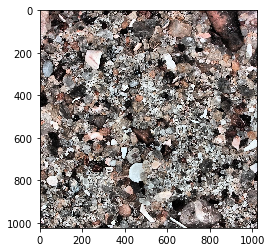

Stats :
[0.218 0.273 0.346 0.429 0.621 1.283 1.821 2.04  2.241 2.532 2.873]


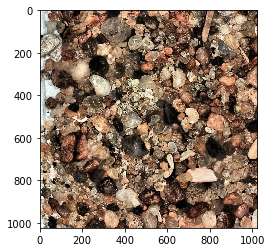

Stats :
[0.164 0.18  0.196 0.209 0.225 0.265 0.319 0.352 0.386 0.437 0.533]


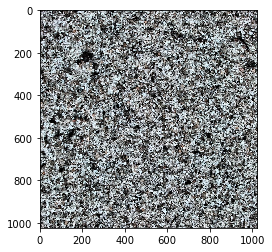

Stats :
[0.175 0.2   0.227 0.254 0.293 0.436 0.862 1.126 1.369 1.855 2.532]


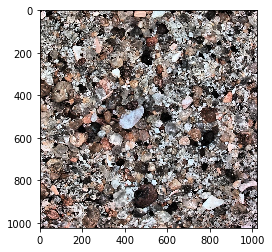

In [14]:
### Use for preprocessed images

x= validation_generator.next()

for i in range(0,batch_size):
    image = x[0][i]   # batch[0] images, batch[1] labels... 
    plt.imshow(image)
    print('Stats :')
    print(x[1][i])
    plt.show()

##### Check Shape

In [15]:
for each in train_generator:
    print(each[1][0].shape)
    break

(11,)


In [16]:
for each in validation_generator:
    print(each[1][0].shape)
    break

(11,)


In [17]:
total_train = 240
total_val = 60

### Model Development

#### Set Weights and Biases Tracking

In [18]:
## these should reflect the model architecture values, I might not be consistent. This is mostly used for tracking what is the best model and its parameters

wandb.init(
  project="sandcam",
  # Set entity to specify your username or team name
  # ex: entity="wandb",
  config={
      "baseFilter": 32,
      "kernelSize": (6,6),
      "stride" : (1,1),
      "dlayer_0": 512,
      "activation_0": "relu",
      "dlayer_1": 128,
      "activation_1": "relu",
      "dlayer_2": 64,
      "activation_2": "relu",
      "dlayer_3": 11,
      "activation_3": "relu",
      "dropout": 0.5,
      "optimizer": "Adam",
      "loss": 'mean_squared_error',
      "metric": "accuracy",
      "epoch": 50,
      "batch_size": batch_size,
      "loss_weights": [0.1, 0.1, 0.1, 0.2, 0.5, 1, 0.5, 0.2, 0.1, 0.1, 0.1 ]
      
  })
config = wandb.config

wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [19]:
#model

# strategy = tf.distribute.MirroredStrategy() ### Distributed is not working, accuracies are not good and if using custom generator its not thread safe

# # with strategy.scope():


#base
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=imshape),
    layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Dropout(config.dropout),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 6, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Dropout(config.dropout),

    layers.Conv2D(128, 6, padding='same', activation='relu'),
    layers.Conv2D(128, 6, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Dropout(config.dropout),

    layers.Conv2D(128, 6, padding='same', activation='relu'),
    layers.Conv2D(128, 6, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Dropout(config.dropout),

    layers.GlobalMaxPooling2D(),

    layers.Dense(config.dlayer_0, activation=config.activation_0),
    layers.Dropout(config.dropout),
    layers.Dense(config.dlayer_1, activation=config.activation_1),
    layers.Dropout(config.dropout),
    layers.Dense(config.dlayer_2, activation=config.activation_2),
    layers.Dropout(config.dropout),
    layers.Dense(config.dlayer_3, activation=config.activation_3)
])

 
# #Large Kernel Size

# model = tf.keras.Sequential([
#     layers.InputLayer(input_shape=imshape),
#     layers.Conv2D(config.baseFilter, config.kernelSize, strides=config.stride, padding='same', activation='relu'),
# #     layers.BatchNormalization(),
#     layers.MaxPool2D(),
#     layers.Dropout(config.dropout),

#     layers.Conv2D(config.baseFilter*2, config.kernelSize, strides=config.stride, padding='same', activation='relu'),
#     layers.Conv2D(config.baseFilter*2, config.kernelSize, strides=config.stride, padding='same', activation='relu'),
# #     layers.BatchNormalization(),
#     layers.MaxPool2D(),
#     layers.Dropout(config.dropout),

#     layers.Conv2D(config.baseFilter*4, config.kernelSize, strides=config.stride, padding='same', activation='relu'),
#     layers.Conv2D(config.baseFilter*4, config.kernelSize, strides=config.stride, padding='same', activation='relu'),
# #     layers.BatchNormalization(),
#     layers.MaxPool2D(),
#     layers.Dropout(config.dropout),

#     layers.Conv2D(config.baseFilter*4, config.kernelSize, strides=config.stride, padding='same', activation='relu'),
#     layers.Conv2D(config.baseFilter*4, config.kernelSize, strides=config.stride, padding='same', activation='relu'),
# #     layers.BatchNormalization(),
#     layers.MaxPool2D(),
#     layers.Dropout(config.dropout),

#     layers.GlobalMaxPooling2D(),

#     layers.Dense(config.dlayer_0, activation=config.activation_0),
#     layers.Dropout(config.dropout),
#     layers.Dense(config.dlayer_1, activation=config.activation_1),
#     layers.Dropout(config.dropout),
#     layers.Dense(config.dlayer_2, activation=config.activation_2),
#     layers.Dropout(config.dropout),
#     layers.Dense(config.dlayer_3, activation=config.activation_3)
# ])

#     #evans model

# baseFilter= 32

# model = tf.keras.Sequential([
#     layers.InputLayer(input_shape=imshape),

#     layers.SeparableConv2D(filters = baseFilter, kernel_size=3, padding='same', activation='relu'),
#     layers.SeparableConv2D(baseFilter*2, 3, padding='same', activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPool2D(),

#     layers.SeparableConv2D(baseFilter*3, 3, padding='same', activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPool2D(),

#     layers.SeparableConv2D(baseFilter*4, 3, padding='same', activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPool2D(),

#     layers.SeparableConv2D(baseFilter*5, 3, padding='same', activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPool2D(),

#     layers.SeparableConv2D(baseFilter*6, 3, padding='same', activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPool2D(),

#     layers.SeparableConv2D(baseFilter*7, 3, padding='same', activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPool2D(),

#     layers.GlobalMaxPooling2D(),
#     #layers.Dropout(0.5),
#     layers.Dense(512, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(len(columns), activation="linear")
# ])



In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1024, 1024, 32)    896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 512, 512, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 512, 512, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 64)      147520    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 256, 64)      0

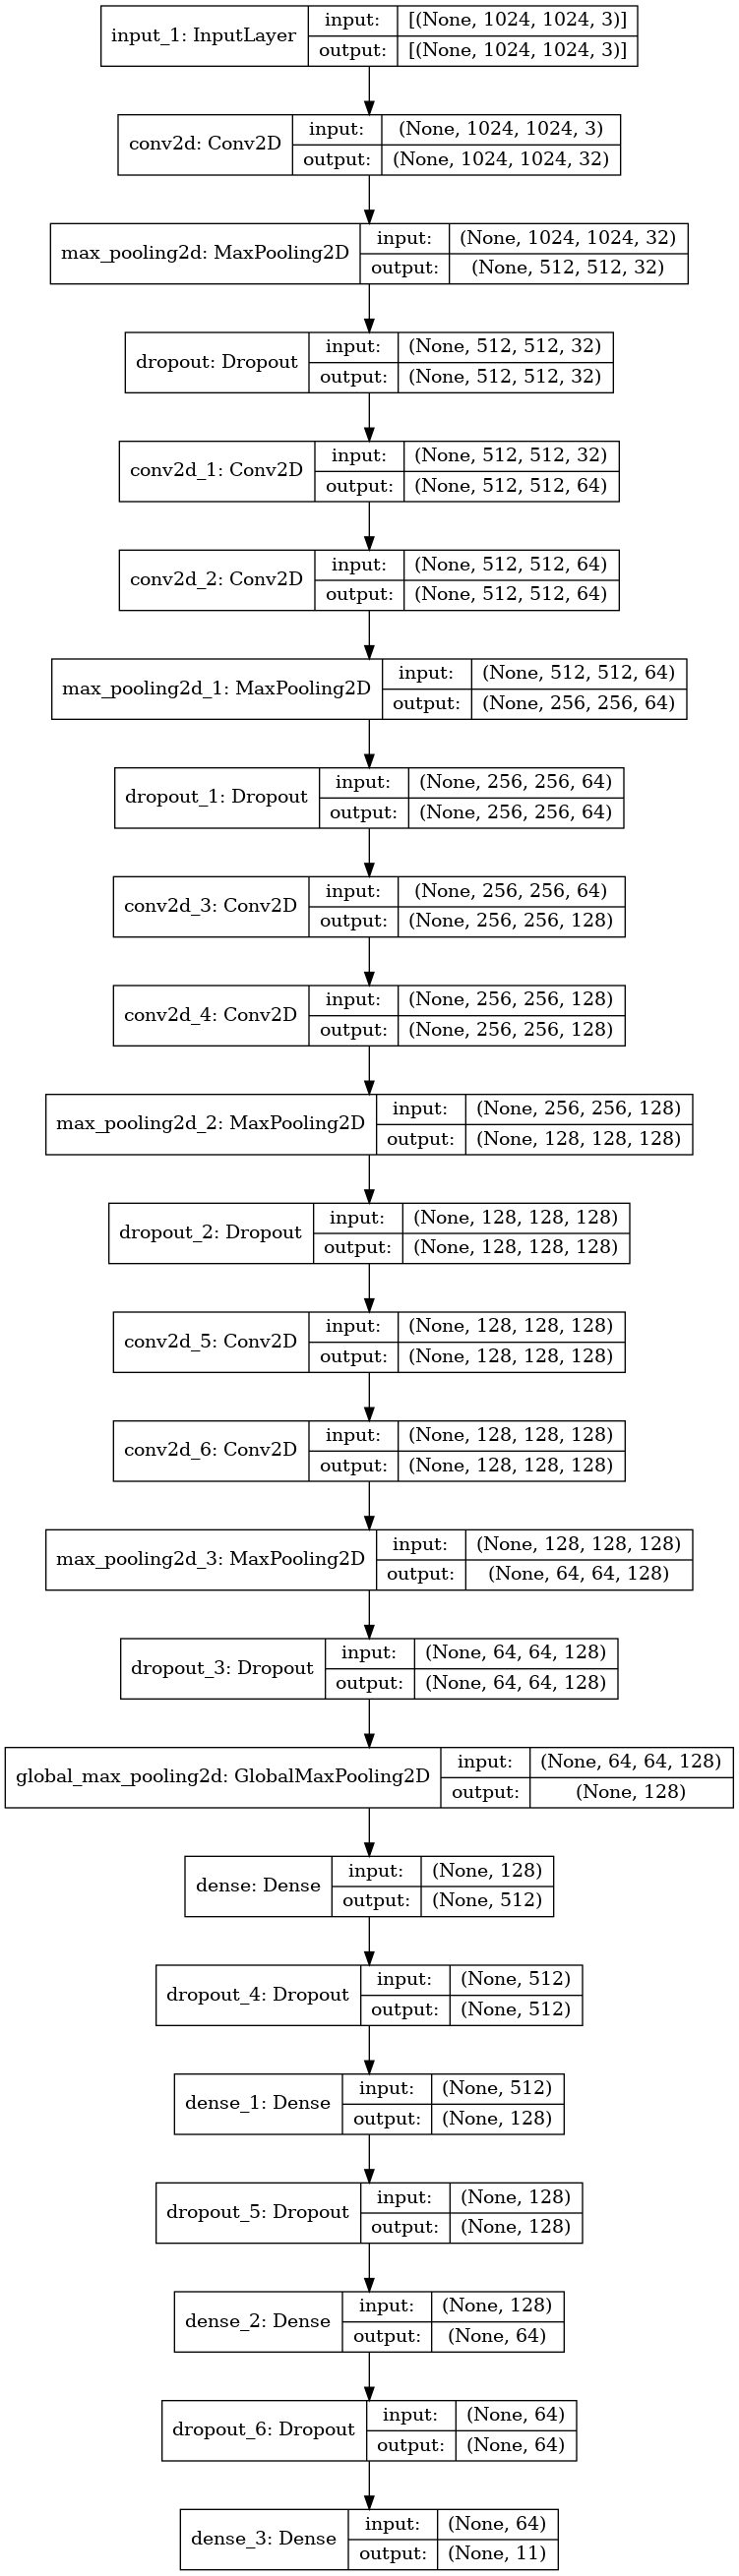

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True)

##### Metrics, Learning Rate, and Model Compilation

In [22]:
# #determine the learning rate

# callbacks = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/10))

# model.compile(loss = 'mean_squared_error',
#              optimizer = tf.keras.optimizers.Adam(lr = 1e-8),
#              metrics = mae_metric)

# history = model.fit(train_generator,
#                     steps_per_epoch = total_train // batch_size,
#                     validation_data = validation_generator,
#                     epochs= 100,
#                     workers = 8,
#                     validation_steps =  total_val // batch_size,
#                     callbacks =[callbacks])

In [23]:
# define other metrics
mae_metric = tf.keras.metrics.MeanAbsoluteError(name='mae')
mape_metric = tf.keras.metrics.MeanAbsolutePercentageError(name='mape')

model._name = "SandCam_CNN"


clr_triangular = CyclicLR(mode='triangular') ### not using it

model.compile(loss='mean_squared_error', 
          optimizer=tf.keras.optimizers.Adam(),
          metrics = mape_metric,
          loss_weights = config.loss_weights
         )


##### Callbacks

In [24]:
# define a callback

early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                             patience = 20, 
                                             restore_best_weights = True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor = 0.2,
                                                 verbose = 1,
                                                 patience=10)

logging_callback = WandbCallback(log_evaluation=True)

##### Train and Validate the model

In [25]:
epochs = 200

#train the model
history = model.fit(train_generator,
                    steps_per_epoch = total_train // batch_size,
                    validation_data = validation_generator,
                    validation_steps =  total_val // batch_size,
                    epochs= 200,
                    workers = 8,
                    callbacks =[early_stop, reduce_lr, logging_callback]) #clr_triangular for slanted learning rate
wandb.finish()

wandb: WARNING WandbCallback is unable to log validation data. When using a generator for validation_data, you must pass validation_steps


Epoch 1/200
60/60 [==============================] - 48s 523ms/step - loss: 0.0634 - mape: 87.6555 - val_loss: 0.1501 - val_mape: 87.0799
Epoch 2/200
60/60 [==============================] - 31s 522ms/step - loss: 0.0488 - mape: 80.5490 - val_loss: 0.1324 - val_mape: 75.4768
Epoch 3/200
60/60 [==============================] - 32s 528ms/step - loss: 0.0454 - mape: 81.4150 - val_loss: 0.1216 - val_mape: 68.1156
Epoch 4/200
60/60 [==============================] - 33s 541ms/step - loss: 0.0422 - mape: 74.5989 - val_loss: 0.1030 - val_mape: 60.6897
Epoch 5/200
60/60 [==============================] - 32s 539ms/step - loss: 0.0420 - mape: 71.0344 - val_loss: 0.1145 - val_mape: 58.4903
Epoch 6/200
60/60 [==============================] - 33s 540ms/step - loss: 0.0402 - mape: 70.5836 - val_loss: 0.1031 - val_mape: 53.6413
Epoch 7/200
60/60 [==============================] - 33s 542ms/step - loss: 0.0330 - mape: 67.8897 - val_loss: 0.1140 - val_mape: 57.9805
Epoch 8/200
60/60 [===============

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▅▄▃▃▃▁▃▂▂▂▂▁▃▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
lr,███████████████████████▁▁▁▁▁▁▁▁▁▁
mape,█▇▇▆▅▅▄▄▃▄▃▃▃▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▄▅▄▅▃▃▃▃▃▁▃▃▂▃▃▃▃▃▂▃▃▃▃▂▂▂▂▂▂▂
val_mape,█▆▅▄▄▃▄▃▂▂▂▂▁▂▁▂▁▁▂▂▁▂▁▁▂▁▂▂▂▂▂▂▂
best_epoch,12
best_val_loss,0.06374
epoch,32
loss,0.03385
lr,0.0002


#### Model Performance

In [26]:
from IPython.display import IFrame

IFrame("https://wandb.ai/chk_null/sandcam/workspace?workspace=user-chk_null", width="100%", height=720)

In [27]:
### Static Plotting of Performance

# #look at the metrics from training
# %matplotlib inline

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(len(loss))

# plt.plot(epochs, loss, 'r', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.ylim(0,1)

# plt.title('Training and validation loss (MSE)')
# plt.legend(loc=0)
# plt.figure()
# plt.show()

# mae = history.history['mae']
# val_mae = history.history['val_mae']

# plt.plot(epochs, mae, 'r', label='Training MAE')
# plt.plot(epochs, val_mae, 'b', label='Validation MAE')
# plt.ylim(0,1)

# plt.title('Training and validation mae')
# plt.legend(loc=0)
# plt.figure()
# plt.show()


### Saved Models

#### Original Model

In [28]:
#save the model. all saves are done in a log folder which is git ignored. 
#Create the folder log and subfolder saved_model for this to run.

filepath = './log/saved_model/sandcam.h5'
model.save(filepath)


In [29]:
#model size

print(
    "Size of the model: %.2f Mb"
    % (os.path.getsize(filepath) / float(2 ** 20))
)


Size of the model: 27.26 Mb


#### Sparsification

Using growing sparsificaiton starting at 50% to final 90%

In [30]:
### Have to do W&B init for each model run to track results

wandb.init(
  project="sandcam",
  # Set entity to specify your username or team name
  # ex: entity="wandb",
  config={
      "dlayer_0": 512,
      "activation_0": "relu",
      "dlayer_1": 128,
      "activation_1": "relu",
      "dlayer_2": 64,
      "activation_2": "relu",
      "dlayer_3": 11,
      "activation_3": "relu",
      "dropout": 0.5,
      "optimizer": "Adam",
      "loss": 'mean_squared_error',
      "metric": "accuracy",
      "epoch": 50,
      "batch_size": batch_size,
      "loss_weights": [0.1, 0.1, 0.1, 0.2, 0.5, 1, 0.5, 0.2, 0.1, 0.1, 0.1 ]
      
  })
config = wandb.config

wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [31]:
#prune
epochs = 200

end_step = np.ceil(1.0 * total_train / batch_size).astype(np.int32) * epochs

pruning_schedule = tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                   final_sparsity=0.90,
                                                   begin_step=0,
                                                   end_step=end_step,
                                                   frequency=100)

model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model, pruning_schedule=pruning_schedule)
model_for_pruning.summary()

/usr/lib/python3/dist-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "SandCam_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv2d ( (None, 1024, 1024, 32)    1762      
_________________________________________________________________
prune_low_magnitude_max_pool (None, 512, 512, 32)      1         
_________________________________________________________________
prune_low_magnitude_dropout  (None, 512, 512, 32)      1         
_________________________________________________________________
prune_low_magnitude_conv2d_1 (None, 512, 512, 64)      36930     
_________________________________________________________________
prune_low_magnitude_conv2d_2 (None, 512, 512, 64)      294978    
_________________________________________________________________
prune_low_magnitude_max_pool (None, 256, 256, 64)      1         
_________________________________________________________________
prune_low_magnitude_dropout_ (None, 256, 256, 64)      

In [32]:
logdir = './log/'

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
  early_stop, 
  reduce_lr,  
  logging_callback  
]

model_for_pruning.compile(
    optimizer='adam',
    loss='mean_squared_error', 
    metrics=mape_metric
)
  
model_for_pruning.fit(train_generator, 
    steps_per_epoch = total_train // batch_size, 
    epochs = epochs, validation_data = validation_generator, 
    validation_steps = total_val // batch_size, shuffle=True, callbacks = callbacks)

wandb: WARNING WandbCallback is unable to log validation data. When using a generator for validation_data, you must pass validation_steps


Epoch 1/200
60/60 [==============================] - 34s 496ms/step - loss: 0.3595 - mape: 52.4595 - val_loss: 0.9170 - val_mape: 37.8608
Epoch 2/200
60/60 [==============================] - 29s 486ms/step - loss: 0.3507 - mape: 54.8855 - val_loss: 0.9306 - val_mape: 39.7920
Epoch 3/200
60/60 [==============================] - 29s 486ms/step - loss: 0.3658 - mape: 49.0553 - val_loss: 0.8574 - val_mape: 37.7765
Epoch 4/200
60/60 [==============================] - 29s 484ms/step - loss: 0.3472 - mape: 50.8188 - val_loss: 0.8458 - val_mape: 38.5814
Epoch 5/200
60/60 [==============================] - 29s 484ms/step - loss: 0.3512 - mape: 52.1164 - val_loss: 0.8187 - val_mape: 39.9391
Epoch 6/200
60/60 [==============================] - 29s 483ms/step - loss: 0.3234 - mape: 50.8269 - val_loss: 0.8843 - val_mape: 37.9733
Epoch 7/200
60/60 [==============================] - 29s 481ms/step - loss: 0.3551 - mape: 50.1833 - val_loss: 0.8454 - val_mape: 38.8932
Epoch 8/200
60/60 [===============

#### Pruned Model Evaluation

In [33]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(validation_generator, verbose=0)

print('Pruned validation data MAPE accuracy:', model_for_pruning_accuracy)

Pruned validation data MAPE accuracy: 27.664121627807617


#### Export Pruned Model

In [34]:
from tensorflow_model_optimization.sparsity import keras as sparsity

final_model = sparsity.strip_pruning(model_for_pruning)
final_model.summary()

Model: "SandCam_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1024, 1024, 32)    896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 512, 512, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 512, 512, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 64)      147520    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 256, 64)      

In [35]:
from tensorflow.keras.models import load_model
import numpy as np

### Sparsification per layer
for i, w in enumerate(final_model.get_weights()):
    print(
        "{} -- Total:{}, Zeros: {:.2f}%".format(
            final_model.weights[i].name, w.size, np.sum(w == 0) / w.size * 100
        )
    )

conv2d/kernel:0 -- Total:864, Zeros: 56.60%
conv2d/bias:0 -- Total:32, Zeros: 0.00%
conv2d_1/kernel:0 -- Total:18432, Zeros: 56.60%
conv2d_1/bias:0 -- Total:64, Zeros: 0.00%
conv2d_2/kernel:0 -- Total:147456, Zeros: 56.60%
conv2d_2/bias:0 -- Total:64, Zeros: 0.00%
conv2d_3/kernel:0 -- Total:294912, Zeros: 56.60%
conv2d_3/bias:0 -- Total:128, Zeros: 0.00%
conv2d_4/kernel:0 -- Total:589824, Zeros: 56.60%
conv2d_4/bias:0 -- Total:128, Zeros: 0.00%
conv2d_5/kernel:0 -- Total:589824, Zeros: 56.60%
conv2d_5/bias:0 -- Total:128, Zeros: 0.00%
conv2d_6/kernel:0 -- Total:589824, Zeros: 56.60%
conv2d_6/bias:0 -- Total:128, Zeros: 0.00%
dense/kernel:0 -- Total:65536, Zeros: 56.60%
dense/bias:0 -- Total:512, Zeros: 0.59%
dense_1/kernel:0 -- Total:65536, Zeros: 56.60%
dense_1/bias:0 -- Total:128, Zeros: 0.00%
dense_2/kernel:0 -- Total:8192, Zeros: 56.60%
dense_2/bias:0 -- Total:64, Zeros: 0.00%
dense_3/kernel:0 -- Total:704, Zeros: 56.53%
dense_3/bias:0 -- Total:11, Zeros: 0.00%


##### Pruned Model Size

In [36]:
import tempfile
import zipfile

_, new_pruned_keras_file = tempfile.mkstemp(".h5")

# new_pruned_keras_file = "./log/saved_model/pruned_model.pb"
print("Saving pruned model to: ", new_pruned_keras_file)
tf.keras.models.save_model(final_model, new_pruned_keras_file, include_optimizer=False)
print(
    "Size of the pruned model: %.2f Mb"
    % (os.path.getsize(new_pruned_keras_file) / float(2 ** 20))
)

Saving pruned model to:  /tmp/tmpndwog4z1.h5
Size of the pruned model: 9.10 Mb


In [37]:
pruned_model_file = "./log/saved_model/pruned_model.h5"

final_model.save(pruned_model_file)

## Quantization

#### Post training quantization

16-Bit float quantization. 

In [38]:
#quantize

keras_model = tf.keras.models.load_model(new_pruned_keras_file)

tflite_fullint_model_file = "./log/saved_model/post_fullint_quantized.tflite"

# converter = tf.lite.TFLiteConverter.from_saved_model('../log/saved_model/pruned_model.pb')

converter = tf.lite.TFLiteConverter.from_keras_model(final_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]



num_calibration_steps = 1
def representative_dataset_gen():
    for _ in range(num_calibration_steps):
        # Get sample input data as a numpy array in a method of your choosing.
        x =np.concatenate([validation_generator.next()[0] for i in range(validation_generator.__len__())])
        print(x.shape)
        yield [x]
converter.representative_dataset = representative_dataset_gen

### Integer 8-Bit
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.int8  # or tf.uint8
# converter.inference_output_type = tf.int8  # or tf.uint8

### Float 16-Bit
converter.target_spec.supported_types = [tf.float16]


tflite_model = converter.convert()
with open(tflite_fullint_model_file, "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp2y58qmo4/assets


#####  Quantized Model Size

In [39]:
print(
    "Size of the quantized model before compression: %.2f Mb"
    % (os.path.getsize(tflite_fullint_model_file) / float(2 ** 20))
)

print(
    "Size of the quantized model after compression: %.2f Mb"
    % (os.path.getsize(tflite_fullint_model_file) / float(2 ** 20))
)

Size of the quantized model before compression: 4.53 Mb
Size of the quantized model after compression: 4.53 Mb


#### Quantized Model Evaluation

In [40]:
x=[]
y=[]
validation_generator.reset()
x=np.concatenate([validation_generator.next()[0] for i in range(validation_generator.__len__())])
y=np.concatenate([validation_generator.next()[1] for i in range(validation_generator.__len__())])
print(x.shape)
print(y.shape)

(60, 1024, 1024, 3)
(60, 11)


In [41]:

interpreter = tf.lite.Interpreter(model_path=str(tflite_fullint_model_file))

interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

preds = []

y_pred = []
y_true = []


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def eval_model(interpreter, x_test, y_test):
    total_seen = 0
    mape = []

    for img, label in zip(x_test, y_test):
        
        if input_details['dtype'] == np.int8:
            input_scale, input_zero_point = input_details["quantization"]
            img = img / input_scale + input_zero_point
        
        inp = np.expand_dims(img, axis=0).astype(input_details["dtype"]) #change here for different quantization
        
        total_seen += 1
        interpreter.set_tensor(input_index, inp) 
        interpreter.invoke()
        
        predictions = interpreter.get_tensor(output_index)
#         print(predictions)
        preds.append(predictions[0])
        

        e_mape = mean_absolute_percentage_error(label, preds)
        print(e_mape)
        mape.append(e_mape)
    return mape


print("Quantized Model MAPE evaluation: %f" % np.mean(eval_model(interpreter, x, y)))



144.87449073047722
41.95256033228391
183.87932009083278
41.20390786349444
48.10622682739798
98.56186294164456
62.24253795432202
27.55314908298646
31.57983659382284
37.15511574624398
98.97693629291258
59.059757220297946
45.84595226299106
41.926502018824294
27.66250595995423
45.96936200430684
28.23890008962824
68.2174936321291
97.03901376786361
56.82173266584961
46.80157902546627
37.63854189975332
55.953943025763685
24.208912512511194
39.33852589019447
46.06210861926544
33.596934148128845
37.49086263322831
82.917653451529
60.1422467690777
39.82414607129188
25.060694719620734
49.07164415515714
32.15434231595575
32.9264374827179
52.12323576884291
48.64806781749734
44.12688870732712
38.00830862396524
52.78095456742411
24.946838937384364
105.36213718299805
51.537142711008634
44.144297946384484
61.557763549701825
33.44795397219749
29.899856427062392
40.187296536538184
30.787868000921247
84.7342391653805
42.9929975827229
33.126133050500925
31.43335903756074
50.662353433290484
37.21276454888711